In [2]:
# ====================================================================
# BLOC 1: IMPORTS and CONFIGURATION
# ====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("="*80)
print("        UBER RIDE PRICE PREDICTION - MACHINE LEARNING PROJECT")
print("="*80)
print("Models: K-Nearest Neighbors (KNN) & Linear Regression")
print("="*80)

        UBER RIDE PRICE PREDICTION - MACHINE LEARNING PROJECT
Models: K-Nearest Neighbors (KNN) & Linear Regression


In [3]:
# ====================================================================
# BLOC 2: Data loading  
# ====================================================================
print("\n[STEP 1] LOADING DATASET...")
print("-" * 80)

try:
    rides_df = pd.read_csv('cab_rides.csv')
    weather_df = pd.read_csv('weather.csv')
    print("✓ Dataset loaded successfully!")
except FileNotFoundError:
    print("ERROR: Files not found!")
    print("Please download the dataset from:")
    print("https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices")
    raise

print(f"\nRides dataset: {rides_df.shape[0]} rows, {rides_df.shape[1]} columns")
print(f"Weather dataset: {weather_df.shape[0]} rows, {weather_df.shape[1]} columns")



[STEP 1] LOADING DATASET...
--------------------------------------------------------------------------------
✓ Dataset loaded successfully!

Rides dataset: 693071 rows, 10 columns
Weather dataset: 6276 rows, 8 columns


In [4]:
# ====================================================================
# BLOC 3: initial data exploration
# ====================================================================
print("\n[STEP 2] INITIAL DATA EXPLORATION")
print("-" * 80)

print("\n--- Rides Dataset Structure ---")
print(rides_df.head(3))
print("\nColumn Names:", rides_df.columns.tolist())
print("\nData Types:")
print(rides_df.dtypes)

print("\n--- Basic Statistics ---")
print(rides_df.describe())

print("\n--- Checking for Missing Values ---")
missing_values = rides_df.isnull().sum()
print(missing_values[missing_values > 0])

print("\n--- Target Variable (Price) Analysis ---")
print(f"Minimum price: ${rides_df['price'].min():.2f}")
print(f"Maximum price: ${rides_df['price'].max():.2f}")
print(f"Average price: ${rides_df['price'].mean():.2f}")
print(f"Median price: ${rides_df['price'].median():.2f}")
print(f"Missing prices: {rides_df['price'].isnull().sum()}")



[STEP 2] INITIAL DATA EXPLORATION
--------------------------------------------------------------------------------

--- Rides Dataset Structure ---
   distance cab_type     time_stamp    destination            source  price  surge_multiplier                                    id    product_id    name
0      0.44     Lyft  1544952607890  North Station  Haymarket Square    5.0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line  Shared
1      0.44     Lyft  1543284023677  North Station  Haymarket Square   11.0               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier     Lux
2      0.44     Lyft  1543366822198  North Station  Haymarket Square    7.0               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft    Lyft

Column Names: ['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price', 'surge_multiplier', 'id', 'product_id', 'name']

Data Types:
distance            float64
cab_type             object
time_stamp            int64
de


[STEP 3] EXPLORATORY DATA ANALYSIS (EDA)
--------------------------------------------------------------------------------
✓ Saved: visualizations/01_eda_price_analysis.png


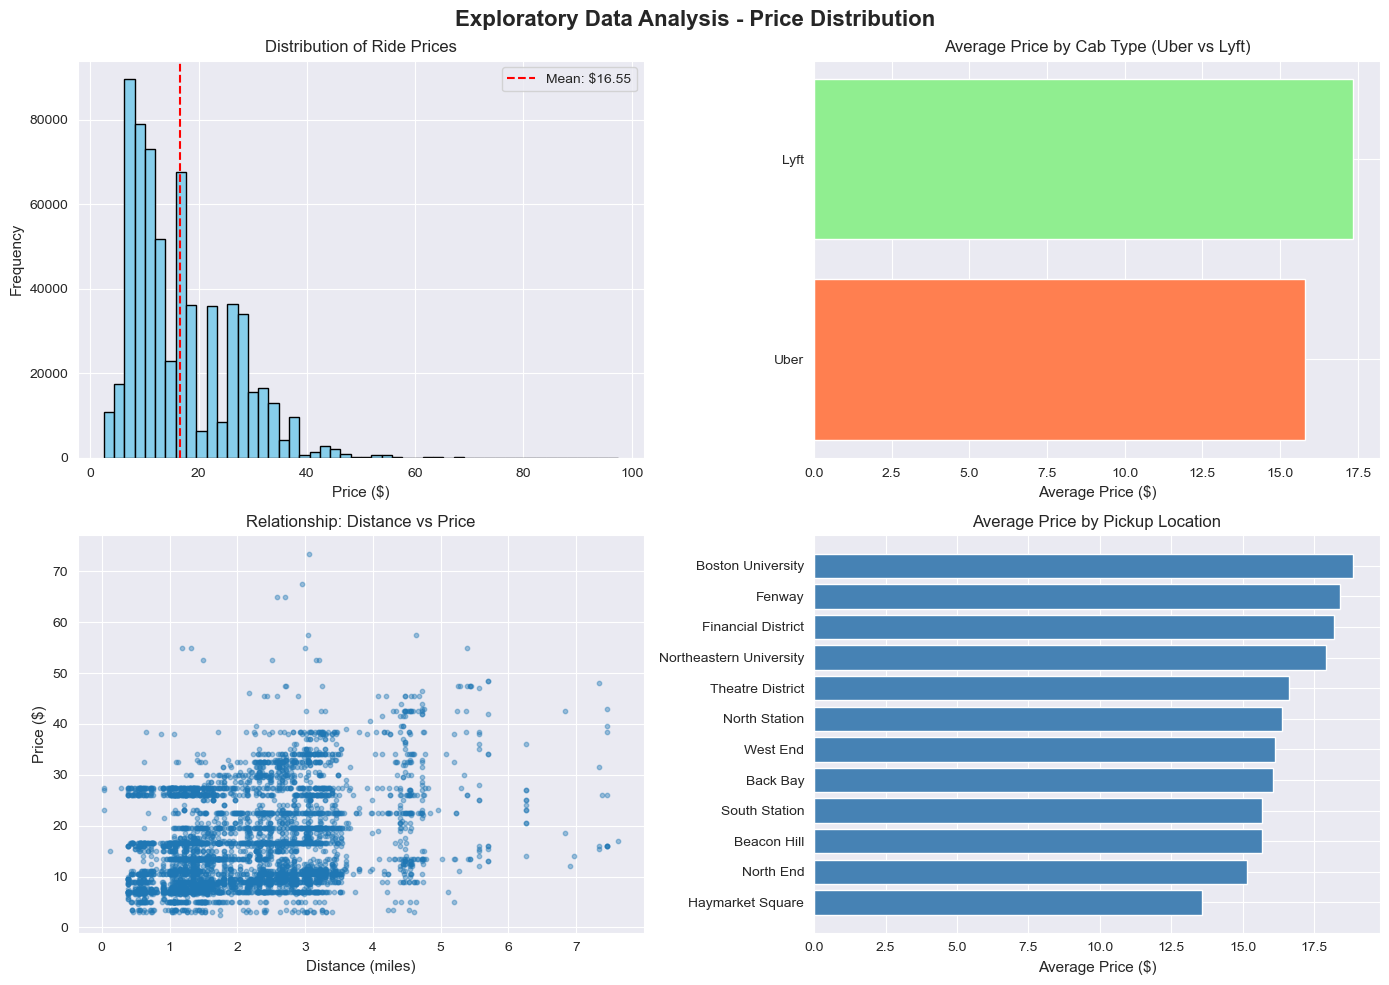

In [5]:
# ====================================================================
# BLOC 4: Exploratory Data Analysis (EDA) Visualizations
# ====================================================================
print("\n[STEP 3] EXPLORATORY DATA ANALYSIS (EDA)")
print("-" * 80)

import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Exploratory Data Analysis - Price Distribution', fontsize=16, fontweight='bold')

axes[0, 0].hist(rides_df['price'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Price ($)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Ride Prices')
axes[0, 0].axvline(rides_df['price'].mean(), color='red', linestyle='--', 
                    label=f'Mean: ${rides_df["price"].mean():.2f}')
axes[0, 0].legend()

price_by_type = rides_df.groupby('cab_type')['price'].mean().sort_values()
axes[0, 1].barh(price_by_type.index, price_by_type.values, color=['coral', 'lightgreen'])
axes[0, 1].set_xlabel('Average Price ($)', fontsize=11)
axes[0, 1].set_title('Average Price by Cab Type (Uber vs Lyft)')

sample_data = rides_df.dropna(subset=['distance', 'price']).sample(min(5000, len(rides_df)))
axes[1, 0].scatter(sample_data['distance'], sample_data['price'], alpha=0.4, s=10)
axes[1, 0].set_xlabel('Distance (miles)', fontsize=11)
axes[1, 0].set_ylabel('Price ($)', fontsize=11)
axes[1, 0].set_title('Relationship: Distance vs Price')

price_by_source = rides_df.groupby('source')['price'].mean().sort_values()
axes[1, 1].barh(price_by_source.index, price_by_source.values, color='steelblue')
axes[1, 1].set_xlabel('Average Price ($)', fontsize=11)
axes[1, 1].set_title('Average Price by Pickup Location')

plt.tight_layout()
plt.savefig('visualizations/01_eda_price_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/01_eda_price_analysis.png")
plt.show()


In [6]:
# ====================================================================
# BLOC 5: CATEGORICAL ANALYSIS
# ====================================================================
print("\n--- Categorical Variables Analysis ---")
print(f"Cab types: {rides_df['cab_type'].unique()}")
print(f"Number of different ride services: {rides_df['name'].nunique()}")
print(f"Pickup locations: {rides_df['source'].unique()}")
print(f"Dropoff locations: {rides_df['destination'].unique()}")

print("\n--- Cab Type Distribution ---")
print(rides_df['cab_type'].value_counts())



--- Categorical Variables Analysis ---
Cab types: ['Lyft' 'Uber']
Number of different ride services: 13
Pickup locations: ['Haymarket Square' 'Back Bay' 'North End' 'North Station' 'Beacon Hill'
 'Boston University' 'Fenway' 'South Station' 'Theatre District'
 'West End' 'Financial District' 'Northeastern University']
Dropoff locations: ['North Station' 'Northeastern University' 'West End' 'Haymarket Square'
 'South Station' 'Fenway' 'Theatre District' 'Beacon Hill' 'Back Bay'
 'North End' 'Financial District' 'Boston University']

--- Cab Type Distribution ---
cab_type
Uber    385663
Lyft    307408
Name: count, dtype: int64



[STEP 4] DATA CLEANING AND PREPROCESSING
--------------------------------------------------------------------------------
Initial dataset size: 693071 rows
After removing missing prices: 637976 rows
✓ Filled missing surge_multiplier values with 1.0
✓ Removed 0 rows with missing critical data
Q1 = $9.00
Q3 = $22.50
IQR = $13.50
Lower Bound = $-11.25
Upper Bound = $42.75
✓ Removed 5589 price outliers (IQR method)
  Price range after cleaning: $2.50 - $42.50

Final cleaned dataset: 632387 rows, 10 columns


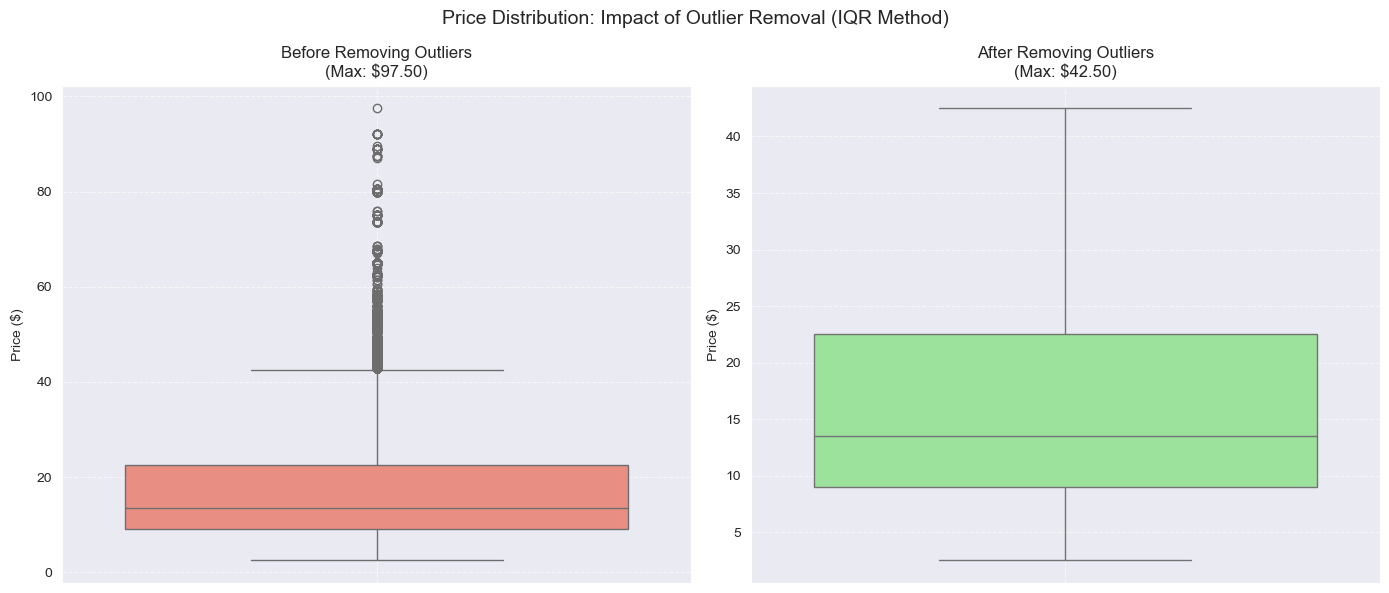

In [9]:

# ====================================================================
# BLOC 6: DATA CLEANING AND PREPROCESSING
# ====================================================================
print("\n[STEP 4] DATA CLEANING AND PREPROCESSING")
print("-" * 80)

df = rides_df.copy()
print(f"Initial dataset size: {df.shape[0]} rows")

df = df.dropna(subset=['price'])
print(f"After removing missing prices: {df.shape[0]} rows")

df['surge_multiplier'] = df['surge_multiplier'].fillna(1.0)
print("✓ Filled missing surge_multiplier values with 1.0")

initial_count = len(df)
df = df.dropna(subset=['distance', 'cab_type', 'source', 'destination'])
print(f"✓ Removed {initial_count - len(df)} rows with missing critical data")

# Handle outliers in price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Q1 = ${Q1:.2f}")
print(f"Q3 = ${Q3:.2f}")
print(f"IQR = ${IQR:.2f}")
print(f"Lower Bound = ${lower_limit:.2f}")
print(f"Upper Bound = ${upper_limit:.2f}")

df_before_outliers = df.copy() 

outliers_count = len(df[(df['price'] < lower_limit) | (df['price'] > upper_limit)])
df = df[(df['price'] >= lower_limit) & (df['price'] <= upper_limit)]
print(f"✓ Removed {outliers_count} price outliers (IQR method)")
print(f"  Price range after cleaning: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

print(f"\nFinal cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns")

plt.figure(figsize=(14, 6))
# Plot 1: Before removing outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_before_outliers['price'], color='salmon')
plt.title(f'Before Removing Outliers\n(Max: ${df_before_outliers["price"].max():.2f})')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'], color='lightgreen')
plt.title(f'After Removing Outliers\n(Max: ${df["price"].max():.2f})')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Price Distribution: Impact of Outlier Removal (IQR Method)', fontsize=14)
plt.tight_layout()
plt.show()
# -------------------------------------------------------

In [7]:
# ====================================================================
# BLOC 7: FEATURE ENGINEERING 
# ====================================================================
print("\n[STEP 5] FEATURE ENGINEERING")
print("-" * 80)

df['time_stamp'] = pd.to_datetime(df['time_stamp'])

print("Creating time-based features...")
df['hour_of_day'] = df['time_stamp'].dt.hour
df['day_of_week'] = df['time_stamp'].dt.dayofweek
df['month'] = df['time_stamp'].dt.month
df['day_of_month'] = df['time_stamp'].dt.day

def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour_of_day'].apply(get_time_period)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_rush_hour'] = ((df['hour_of_day'].between(7, 9)) | 
                       (df['hour_of_day'].between(17, 19))).astype(int)

print(f"✓ Created 6 new time-based features")


[STEP 5] FEATURE ENGINEERING
--------------------------------------------------------------------------------
Creating time-based features...
✓ Created 6 new time-based features


In [8]:
# ====================================================================
# BLOC 8: FEATURE ENGINEERING - MERGE with weather
# ====================================================================
print("\nMerging with weather data...")
weather_df['time_stamp'] = pd.to_datetime(weather_df['time_stamp'])
weather_df['location'] = weather_df['location'].str.strip()

weather_agg = weather_df.groupby([
    'location', 
    pd.Grouper(key='time_stamp', freq='H')
]).agg({
    'temp': 'mean',
    'clouds': 'mean',
    'pressure': 'mean',
    'rain': 'mean',
    'humidity': 'mean',
    'wind': 'mean'
}).reset_index()

df['time_hour'] = df['time_stamp'].dt.floor('H')

df = df.merge(
    weather_agg,
    left_on=['source', 'time_hour'],
    right_on=['location', 'time_stamp'],
    how='left',
    suffixes=('', '_weather')
)

weather_cols = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']
for col in weather_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

print(f"✓ Merged weather data - Dataset now has {df.shape[1]} columns")


Merging with weather data...
✓ Merged weather data - Dataset now has 26 columns


In [9]:
# ====================================================================
# BLOC 9: FEATURE ENGINEERING - Distance category
# ====================================================================
def categorize_distance(distance):
    if distance < 2:
        return 'Short'
    elif distance < 5:
        return 'Medium'
    elif distance < 10:
        return 'Long'
    else:
        return 'Very_Long'

df['distance_category'] = df['distance'].apply(categorize_distance)

print("\n--- Summary of Engineered Features ---")
print(f"Total features available: {df.shape[1]}")
print(f"Cleaned samples: {df.shape[0]}")



--- Summary of Engineered Features ---
Total features available: 27
Cleaned samples: 632387


In [10]:
# ====================================================================
# BLOC 10: FEATURE SELECTION AND ENCODING
# ====================================================================
print("\n[STEP 6] FEATURE SELECTION AND ENCODING")
print("-" * 80)

selected_features = [
    'distance', 'surge_multiplier',
    'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
    'cab_type', 'name', 'source', 'destination', 'time_period', 'distance_category',
    'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind'
]

print(f"Selected {len(selected_features)} features for modeling")

X = df[selected_features].copy()
y = df['price'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Encode categorical variables
print("\n--- Encoding Categorical Variables ---")
categorical_features = ['cab_type', 'name', 'source', 'destination', 
                        'time_period', 'distance_category']

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))
    label_encoders[feature] = le
    print(f"✓ Encoded '{feature}': {len(le.classes_)} categories")

if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("✓ Filled remaining missing values with median")


[STEP 6] FEATURE SELECTION AND ENCODING
--------------------------------------------------------------------------------
Selected 19 features for modeling

Feature matrix shape: (632387, 19)
Target vector shape: (632387,)

--- Encoding Categorical Variables ---
✓ Encoded 'cab_type': 2 categories
✓ Encoded 'name': 12 categories
✓ Encoded 'source': 12 categories
✓ Encoded 'destination': 12 categories
✓ Encoded 'time_period': 1 categories
✓ Encoded 'distance_category': 3 categories


In [11]:
# ====================================================================
# BLOC 11: TRAIN-TEST
# ====================================================================
print("\n[STEP 7] SPLITTING DATA INTO TRAIN AND TEST SETS")
print("-" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining price range: ${y_train.min():.2f} - ${y_train.max():.2f}")
print(f"Testing price range: ${y_test.min():.2f} - ${y_test.max():.2f}")



[STEP 7] SPLITTING DATA INTO TRAIN AND TEST SETS
--------------------------------------------------------------------------------
Training set: 505909 samples (80.0%)
Testing set:  126478 samples (20.0%)

Training price range: $2.50 - $42.50
Testing price range: $2.50 - $42.50


In [12]:
# ====================================================================
# BLOC 12: FEATURE STANDARDIZATION
# ====================================================================
print("\n[STEP 8] FEATURE SCALING")
print("-" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Applied StandardScaler to features")
print("  - Mean = 0, Standard Deviation = 1")


[STEP 8] FEATURE SCALING
--------------------------------------------------------------------------------
✓ Applied StandardScaler to features
  - Mean = 0, Standard Deviation = 1


In [ ]:
# ====================================================================
# BLOC 13: KNN - OPTIMISATION
# ====================================================================
print("\n" + "="*80)
print("[MODEL 1] K-NEAREST NEIGHBORS (KNN) REGRESSION")
print("="*80)

k_values = [3, 5, 7, 9, 11, 15, 20, 25]
k_scores = []

print("\n--- Finding Optimal K Value ---")
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    k_scores.append(score)
    print(f"k={k:2d} : R² Score = {score:.4f}")

best_k_idx = np.argmax(k_scores)
best_k = k_values[best_k_idx]
print(f"\n✓ Best k value: {best_k} (R² = {k_scores[best_k_idx]:.4f})")


[MODEL 1] K-NEAREST NEIGHBORS (KNN) REGRESSION

--- Finding Optimal K Value ---


In [ ]:
# ====================================================================
# BLOC 20: VIZUALISATION - OPTIMISATION K
# ====================================================================
print("\n" + "="*80)
print("[STEP 12] CREATING VISUALIZATIONS")
print("="*80)

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('KNN Performance: Finding Optimal K Value', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('visualizations/02_knn_k_optimization.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/02_knn_k_optimization.png")
plt.show()

In [ ]:
# ====================================================================
# BLOC 14: KNN - TRAINING AND EVALUATION
# ====================================================================
print(f"\n--- Training Final KNN Model (k={best_k}) ---")
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully")

y_pred_knn_train = knn_model.predict(X_train_scaled)
y_pred_knn_test = knn_model.predict(X_test_scaled)

# Training set performance
print("\n--- KNN Performance on TRAINING Set ---")
r2_knn_train = r2_score(y_train, y_pred_knn_train)
rmse_knn_train = np.sqrt(mean_squared_error(y_train, y_pred_knn_train))
mae_knn_train = mean_absolute_error(y_train, y_pred_knn_train)

print(f"R² Score:  {r2_knn_train:.4f}")
print(f"RMSE:      ${rmse_knn_train:.2f}")
print(f"MAE:       ${mae_knn_train:.2f}")

# Testing set performance
print("\n--- KNN Performance on TESTING Set ---")
r2_knn_test = r2_score(y_test, y_pred_knn_test)
rmse_knn_test = np.sqrt(mean_squared_error(y_test, y_pred_knn_test))
mae_knn_test = mean_absolute_error(y_test, y_pred_knn_test)

print(f"R² Score:  {r2_knn_test:.4f}")
print(f"RMSE:      ${rmse_knn_test:.2f}")
print(f"MAE:       ${mae_knn_test:.2f}")

In [ ]:
# ====================================================================
# BLOC 15: KNN - CROSS-VALIDATION
# ====================================================================
print("\n--- KNN Cross-Validation (5-fold) ---")
cv_scores_knn = cross_val_score(knn_model, X_train_scaled, y_train, 
                                 cv=5, scoring='r2')
print(f"CV Scores: {cv_scores_knn}")
print(f"Mean CV Score: {cv_scores_knn.mean():.4f} (+/- {cv_scores_knn.std() * 2:.4f})")

In [ ]:
# ====================================================================
# BLOC 16: LINEAR REGRESSION - TRAINING AND EVALUATION
# ====================================================================
print("\n" + "="*80)
print("[MODEL 2] LINEAR REGRESSION")
print("="*80)

print("\n--- Training Linear Regression Model ---")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully")

y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Training set performance
print("\n--- Linear Regression Performance on TRAINING Set ---")
r2_lr_train = r2_score(y_train, y_pred_lr_train)
rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)

print(f"R² Score:  {r2_lr_train:.4f}")
print(f"RMSE:      ${rmse_lr_train:.2f}")
print(f"MAE:       ${mae_lr_train:.2f}")

# Testing set performance
print("\n--- Linear Regression Performance on TESTING Set ---")
r2_lr_test = r2_score(y_test, y_pred_lr_test)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)

print(f"R² Score:  {r2_lr_test:.4f}")
print(f"RMSE:      ${rmse_lr_test:.2f}")
print(f"MAE:       ${mae_lr_test:.2f}")

In [ ]:
# ====================================================================
# BLOC 17: LINEAR REGRESSION - CROSS-VALIDATION 
# ====================================================================
print("\n--- Linear Regression Cross-Validation (5-fold) ---")
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, 
                                cv=5, scoring='r2')
print(f"CV Scores: {cv_scores_lr}")
print(f"Mean CV Score: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

In [ ]:
# ====================================================================
# BLOC 18: FEATURE IMPORTANCE
# ====================================================================
print("\n--- Top 10 Most Important Features (Linear Regression) ---")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(feature_importance.head(10).to_string(index=False))

In [ ]:
# Visualization 5: Feature Importance (Linear Regression)
plt.figure(figsize=(10, 8))
top_15_features = feature_importance.head(15)
colors = ['green' if x > 0 else 'red' for x in top_15_features['Coefficient']]
plt.barh(range(len(top_15_features)), top_15_features['Abs_Coefficient'], color=colors)
plt.yticks(range(len(top_15_features)), top_15_features['Feature'])
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.title('Top 15 Most Influential Features (Linear Regression)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/06_feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/06_feature_importance.png")
plt.show()

print("\n✓ All visualizations created successfully!")

In [ ]:
# ====================================================================
# BLOC 19: MODEL COMPARISON
# ====================================================================
print("\n" + "="*80)
print("[STEP 11] MODEL COMPARISON AND EVALUATION")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': ['R² Score', 'RMSE ($)', 'MAE ($)', 'CV Score (Mean)'],
    'KNN (Train)': [r2_knn_train, rmse_knn_train, mae_knn_train, cv_scores_knn.mean()],
    'KNN (Test)': [r2_knn_test, rmse_knn_test, mae_knn_test, cv_scores_knn.mean()],
    'Linear Reg (Train)': [r2_lr_train, rmse_lr_train, mae_lr_train, cv_scores_lr.mean()],
    'Linear Reg (Test)': [r2_lr_test, rmse_lr_test, mae_lr_test, cv_scores_lr.mean()]
})

print("\n--- PERFORMANCE COMPARISON TABLE ---")
print(comparison_df.to_string(index=False))

if r2_knn_test > r2_lr_test:
    best_model = "K-Nearest Neighbors (KNN)"
    best_r2 = r2_knn_test
    best_rmse = rmse_knn_test
else:
    best_model = "Linear Regression"
    best_r2 = r2_lr_test
    best_rmse = rmse_lr_test

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: ${best_rmse:.2f}")

# Overfitting analysis
print("\n--- Overfitting Analysis ---")
knn_overfit = r2_knn_train - r2_knn_test
lr_overfit = r2_lr_train - r2_lr_test

print(f"KNN - Train vs Test R² difference: {knn_overfit:.4f}")
print(f"  {' Warning: Possible overfitting' if knn_overfit > 0.1 else '✓ Good generalization'}")

print(f"Linear Reg - Train vs Test R² difference: {lr_overfit:.4f}")
print(f"  {' Warning: Possible overfitting' if lr_overfit > 0.1 else '✓ Good generalization'}")

In [ ]:
# ====================================================================
# BLOC 21: VISUALISATION - COMPARAISON DES MODÈLES
# ====================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['KNN', 'Linear Reg']
r2_values = [r2_knn_test, r2_lr_test]
rmse_values = [rmse_knn_test, rmse_lr_test]
mae_values = [mae_knn_test, mae_lr_test]

axes[0].bar(models, r2_values, color=['#3498db', '#e74c3c'], width=0.6)
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('R² Score Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

axes[1].bar(models, rmse_values, color=['#3498db', '#e74c3c'], width=0.6)
axes[1].set_ylabel('RMSE ($)', fontsize=11)
axes[1].set_title('Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[1].text(i, v + 0.1, f'${v:.2f}', ha='center', fontweight='bold')

axes[2].bar(models, mae_values, color=['#3498db', '#e74c3c'], width=0.6)
axes[2].set_ylabel('MAE ($)', fontsize=11)
axes[2].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(mae_values):
    axes[2].text(i, v + 0.1, f'${v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/03_model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/03_model_comparison.png")
plt.show()


In [ ]:
# ====================================================================
# BLOC 22: VISUALISATION - ACTUAL VS PREDICTED
# ====================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sample_size = min(2000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
y_test_sample = y_test.iloc[sample_indices]
y_pred_knn_sample = y_pred_knn_test[sample_indices]
y_pred_lr_sample = y_pred_lr_test[sample_indices]

# KNN
axes[0].scatter(y_test_sample, y_pred_knn_sample, alpha=0.5, s=15, color='steelblue')
axes[0].plot([y_test_sample.min(), y_test_sample.max()],
             [y_test_sample.min(), y_test_sample.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=11)
axes[0].set_ylabel('Predicted Price ($)', fontsize=11)
axes[0].set_title(f'KNN: Actual vs Predicted (R²={r2_knn_test:.4f})', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Linear Regression
axes[1].scatter(y_test_sample, y_pred_lr_sample, alpha=0.5, s=15, color='coral')
axes[1].plot([y_test_sample.min(), y_test_sample.max()],
             [y_test_sample.min(), y_test_sample.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=11)
axes[1].set_ylabel('Predicted Price ($)', fontsize=11)
axes[1].set_title(f'Linear Regression: Actual vs Predicted (R²={r2_lr_test:.4f})', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/04_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/04_actual_vs_predicted.png")
plt.show()

In [ ]:
# ====================================================================
# BLOC 23: VISUALISATION -Residual
# ====================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

residuals_knn = y_test_sample - y_pred_knn_sample
residuals_lr = y_test_sample - y_pred_lr_sample

# KNN Residuals
axes[0].scatter(y_pred_knn_sample, residuals_knn, alpha=0.5, s=15, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)', fontsize=11)
axes[0].set_ylabel('Residuals ($)', fontsize=11)
axes[0].set_title('KNN: Residual Plot', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Linear Regression Residuals
axes[1].scatter(y_pred_lr_sample, residuals_lr, alpha=0.5, s=15, color='coral')
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=11)
axes[1].set_ylabel('Residuals ($)', fontsize=11)
axes[1].set_title('Linear Regression: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/05_residual_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/05_residual_analysis.png")
plt.show()

In [ ]:
# ====================================================================
# 13. SAVE RESULTS
# ====================================================================
print("\n" + "="*80)
print("[STEP 13] SAVING RESULTS")
print("="*80)

# Save model comparison
comparison_df.to_csv('results_model_comparison.csv', index=False)
print("✓ Saved: results_model_comparison.csv")

# Save feature importance
feature_importance.to_csv('results_feature_importance.csv', index=False)
print("✓ Saved: results_feature_importance.csv")

# Save sample predictions for analysis
predictions_sample_df = pd.DataFrame({
    'Actual_Price': y_test_sample.values,
    'KNN_Prediction': y_pred_knn_sample,
    'LR_Prediction': y_pred_lr_sample,
    'KNN_Error': np.abs(y_test_sample.values - y_pred_knn_sample),
    'LR_Error': np.abs(y_test_sample.values - y_pred_lr_sample)
})
predictions_sample_df.to_csv('results_sample_predictions.csv', index=False)
print("✓ Saved: results_sample_predictions.csv")

In [ ]:
# ====================================================================
# 14. FINAL SUMMARY AND INSIGHTS
# ====================================================================
print("\n" + "="*80)
print("FINAL PROJECT SUMMARY")
print("="*80)

print(f"""
📊 DATASET OVERVIEW
{'─'*80}
Total samples processed:        {len(df):,}
Training samples:               {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)
Testing samples:                {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)
Number of features:             {len(selected_features)}
Target variable:                Price (in USD)

🔧 FEATURES USED
{'─'*80}
Numerical Features (8):         distance, surge_multiplier, hour_of_day,
                                day_of_week, month, is_weekend, is_rush_hour,
                                day_of_month

Categorical Features (6):       cab_type, name, source, destination,
                                time_period, distance_category

Weather Features (6):           temp, clouds, pressure, rain, humidity, wind

Total: {len(selected_features)} features

 MODEL 1: K-NEAREST NEIGHBORS (KNN)
{'─'*80}
Algorithm:                      Non-parametric, instance-based learning
Optimal K value:                {best_k}
Training R² Score:              {r2_knn_train:.4f}
Testing R² Score:               {r2_knn_test:.4f}
RMSE (Test):                    ${rmse_knn_test:.2f}
MAE (Test):                     ${mae_knn_test:.2f}
Cross-Validation Score:         {cv_scores_knn.mean():.4f} (±{cv_scores_knn.std()*2:.4f})

 MODEL 2: LINEAR REGRESSION
{'─'*80}
Algorithm:                      Ordinary Least Squares (OLS)
Training R² Score:              {r2_lr_train:.4f}
Testing R² Score:               {r2_lr_test:.4f}
RMSE (Test):                    ${rmse_lr_test:.2f}
MAE (Test):                     ${mae_lr_test:.2f}
Cross-Validation Score:         {cv_scores_lr.mean():.4f} (±{cv_scores_lr.std()*2:.4f})

 WINNING MODEL
{'─'*80}
Best Model:                     {best_model}
R² Score:                       {best_r2:.4f}
RMSE:                           ${best_rmse:.2f}
Interpretation:                 The model explains {best_r2*100:.2f}% of the variance
                                in ride prices.

 KEY FINDINGS
{'─'*80}
1. Top 3 Most Important Features (from Linear Regression):
   ├─ {feature_importance.iloc[0]['Feature']}: {feature_importance.iloc[0]['Abs_Coefficient']:.4f}
   ├─ {feature_importance.iloc[1]['Feature']}: {feature_importance.iloc[1]['Abs_Coefficient']:.4f}
   └─ {feature_importance.iloc[2]['Feature']}: {feature_importance.iloc[2]['Abs_Coefficient']:.4f}

2. Model Performance:
   ├─ Both models show {('good' if best_r2 > 0.7 else 'moderate')} predictive capability
   ├─ {'Low' if abs(r2_knn_train - r2_knn_test) < 0.1 and abs(r2_lr_train - r2_lr_test) < 0.1 else 'Some'} evidence of overfitting
   └─ Cross-validation confirms model stability

3. Practical Application:
   ├─ Average prediction error: ${min(mae_knn_test, mae_lr_test):.2f}
   ├─ Can help riders estimate fare before booking
   └─ Useful for ride-sharing companies for dynamic pricing

Visualizations:
  ✓ 01_eda_price_analysis.png
  ✓ 02_knn_k_optimization.png
  ✓ 03_model_comparison.png
  ✓ 04_actual_vs_predicted.png
  ✓ 05_residual_analysis.png
  ✓ 06_feature_importance.png
""")


In [ ]:
comparison_df = pd.DataFrame({
    'Real price': y_test.values[:10],
    'Predicted Price': knn_model.predict(X_test_scaled[:10])
})

comparison_df['Absolute error'] = abs(
    comparison_df['real price'] - comparison_df['Predicted price']
)

print(comparison_df)
